In [1]:
pip install mplfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from prophet import Prophet

import statsmodels.api as sm
from scipy import stats
import mplfinance as mpf
from plotly import tools
import matplotlib.dates as mdates
import chart_studio.plotly as py
import plotly.figure_factory as ff
import chart_studio.tools as tls
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from chart_studio.plotly import plot, iplot
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


#### 1. Forecasting Saham ADRO

In [3]:
# Load data
adro = pd.read_csv("Stock/ADRO.JK.csv")

# Tambah Kolom Kode Saham
adro['Kode'] = 'ADRO'

# Tampilkan Data
adro

,Date,Open,High,Low,Close,Adj Close,Volume,Kode
0,2008-08-01,1630.0,1680.0,1620.0,1630.0,625.735046,78478500.0,ADRO
1,2008-08-04,1590.0,1630.0,1590.0,1590.0,610.379700,43837000.0,ADRO
2,2008-08-05,1550.0,1580.0,1540.0,1550.0,595.024109,50244500.0,ADRO
3,2008-08-06,1540.0,1570.0,1540.0,1540.0,591.185242,48545500.0,ADRO
4,2008-08-07,1560.0,1570.0,1540.0,1560.0,598.863159,50999500.0,ADRO
...,...,...,...,...,...,...,...,...
3960,2024-08-29,3540.0,3590.0,3500.0,3520.0,3520.000000,63218700.0,ADRO
3961,2024-08-30,3540.0,3590.0,3510.0,3560.0,3560.000000,95767700.0,ADRO
3962,2024-09-02,3590.0,3650.0,3570.0,3610.0,3610.000000,96348100.0,ADRO
3963,2024-09-03,NaN,NaN,NaN,NaN,NaN,NaN,ADRO


In [4]:
# Handle Missing Values
adro = adro.dropna()

# mengecek missing values
adro.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Kode         0
dtype: int64

In [5]:
# mengubah tipe data kolom 'Date' menjadi datetime
adro['Date'] = pd.to_datetime(adro['Date'], format="%Y-%m-%d")

# mengecek informasi dataset
adro.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3963 entries, 0 to 3964
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3963 non-null   datetime64[ns]
 1   Open       3963 non-null   float64       
 2   High       3963 non-null   float64       
 3   Low        3963 non-null   float64       
 4   Close      3963 non-null   float64       
 5   Adj Close  3963 non-null   float64       
 6   Volume     3963 non-null   float64       
 7   Kode       3963 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 278.6+ KB


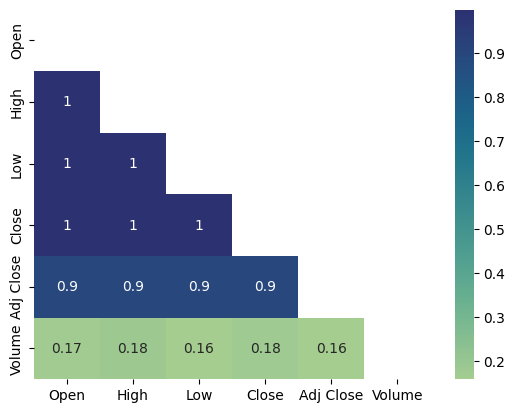

In [6]:
mask_adro = np.triu(np.ones_like(adro.corr(numeric_only=True))).astype(bool)
sns.heatmap(adro.corr(numeric_only=True), annot=True, mask=mask_adro, cmap='crest')
plt.show()

In [7]:
model = Prophet()

# Drop columns
model_df = adro.drop(['Open', 'High', 'Low', 'Volume', 'Kode', 'Adj Close'], axis=1)
model_df.rename(columns={'Close' : 'y', 'Date' : 'ds'}, inplace=True)

model_df

,ds,y
0,2008-08-01,1630.0
1,2008-08-04,1590.0
2,2008-08-05,1550.0
3,2008-08-06,1540.0
4,2008-08-07,1560.0
...,...,...
3959,2024-08-28,3530.0
3960,2024-08-29,3520.0
3961,2024-08-30,3560.0
3962,2024-09-02,3610.0


In [8]:
# Inisialisasi dan latih model dengan penyesuaian parameter
model = Prophet(
    daily_seasonality=True
)

# Latih model
model.fit(model_df)

19:48:58 - cmdstanpy - INFO - Chain [1] start processing
19:49:01 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
# Membuat tanggal prediksi
future_prices = model.make_future_dataframe(periods=365)

# prediksi harga
predict = model.predict(future_prices)
predict[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4323,2025-08-31,4007.575839,3518.556728,4504.841855
4324,2025-09-01,3890.267596,3371.082990,4427.595383
4325,2025-09-02,3896.846411,3367.803589,4354.296653
4326,2025-09-03,3904.432237,3474.480391,4409.885642
4327,2025-09-04,3911.554875,3422.612604,4403.076093


In [10]:
from sklearn.metrics import mean_absolute_error

df_actual = model_df[['ds', 'y']].rename(columns={'y': 'y_actual'})  # Ubah nama kolom 'y' menjadi 'y_actual' untuk perbandingan
df_combined = pd.merge(df_actual, predict[['ds', 'yhat']], on='ds', how='inner')

# Hitung MAE (Mean Absolute Error)
mae = mean_absolute_error(df_combined['y_actual'], df_combined['yhat'])

# Hitung MAPE (Mean Absolute Percentage Error)
mape = (abs(df_combined['y_actual'] - df_combined['yhat']) / df_combined['y_actual']).mean() * 100

print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')

MAE: 253.97
MAPE: 17.00%


In [11]:
df_actual.tail()

,ds,y_actual
3959,2024-08-28,3530.0
3960,2024-08-29,3520.0
3961,2024-08-30,3560.0
3962,2024-09-02,3610.0
3964,2024-09-04,3560.0


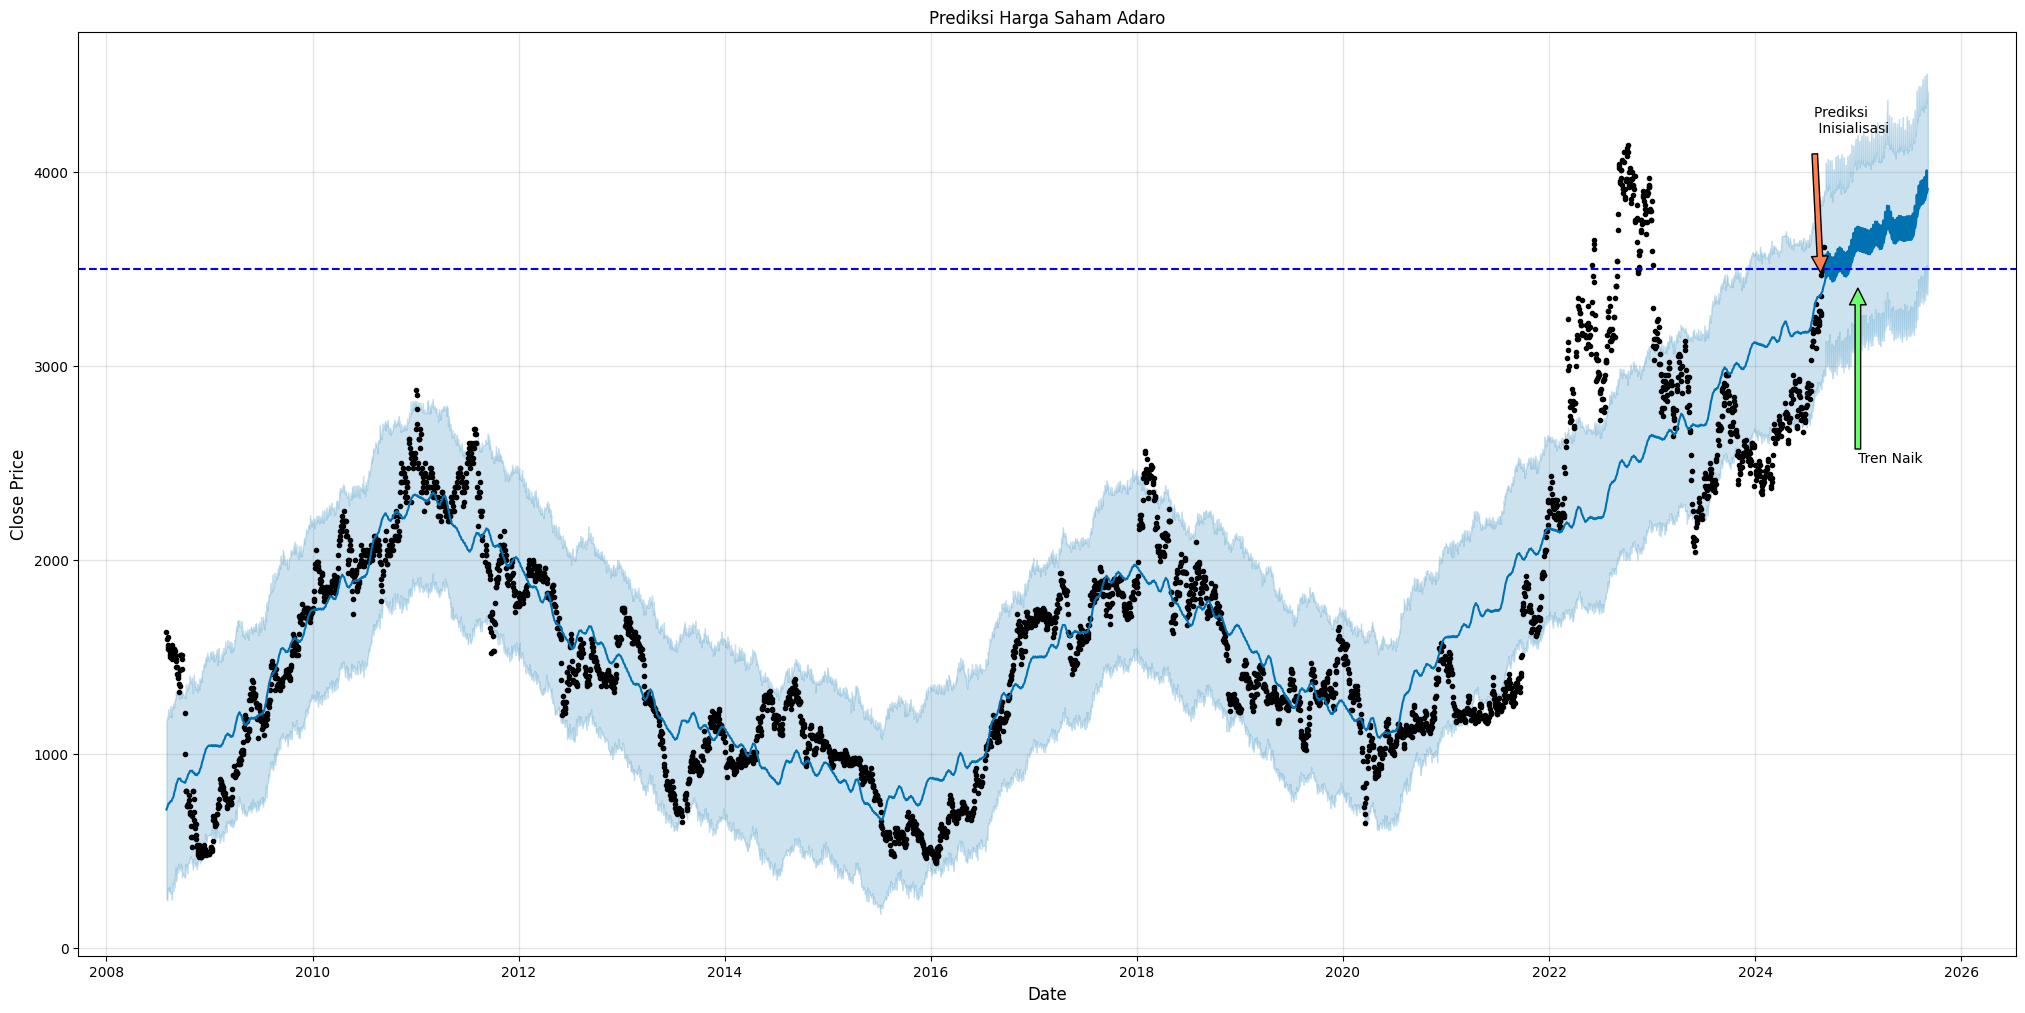

In [12]:
# Dates
start_date = dt.datetime(2024, 7, 27)
start_date1 = mdates.date2num(start_date)

trend_date = dt.datetime(2024, 12, 30)
trend_date1 = mdates.date2num(trend_date)

point_arrow = dt.datetime(2024, 8, 23)
point_arrow1 = mdates.date2num(point_arrow)

# plot
fig, ax1 = plt.subplots(figsize=(25, 12))
model.plot(predict, ax=ax1)
ax1.set_title('Prediksi Harga Saham Adaro')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Close Price', fontsize=12)

# anotasi
ax1.annotate('Prediksi \n Inisialisasi', xy=(point_arrow1, 3400), xytext=(start_date1, 4200), 
             arrowprops=dict(facecolor='#ff7f50', shrink=0.1),
             )
ax1.annotate('Tren Naik', xy=(trend_date1, 3400), xytext=(trend_date1, 2500), 
             arrowprops=dict(facecolor='#6cff6c', shrink=0.0),
             )

ax1.axhline(y=3500, color='b', linestyle='--')
plt.show()

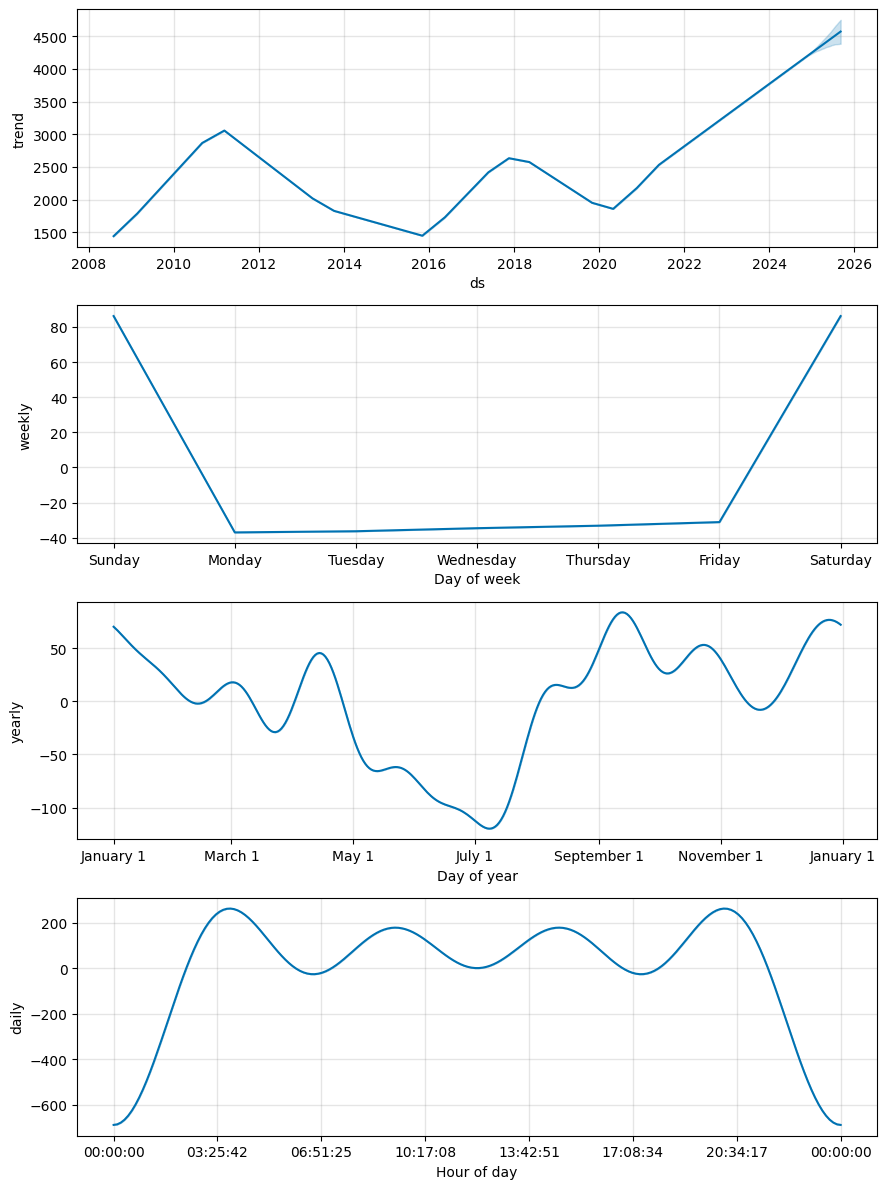

In [13]:
fig2 = model.plot_components(predict)
plt.show()

#### 2. Forecasting Saham BUMI

#### 3. Forecasting Saham BYAN

#### 4. Forecasting Saham GEMS

#### 5. Forecasting Saham INDY

#### 6. Forecasting Saham ITMG

#### 7. Forecasting Saham PTBA

In [20]:
#Membuat prediksi dengan Prophet
m_p = Prophet()
m_p.fit(model_df)
future = m_p.make_future_dataframe(periods = 13, freq = 'M')
prediction = m_p.predict(future)
prediction.tail(3)

20:45:46 - cmdstanpy - INFO - Chain [1] start processing
20:45:48 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3973,2025-07-31,3960.895102,3290.910554,4301.720716,3762.776446,4154.970346,-160.835171,-160.835171,-160.835171,-149.144742,-149.144742,-149.144742,-11.690429,-11.690429,-11.690429,0.0,0.0,0.0,3800.059930
3974,2025-08-31,4001.741208,3890.692230,4937.687599,3776.988496,4220.906235,419.496384,419.496384,419.496384,376.089028,376.089028,376.089028,43.407356,43.407356,43.407356,0.0,0.0,0.0,4421.237592
3975,2025-09-30,4041.269698,3406.638032,4514.508933,3784.316269,4291.667829,-119.786566,-119.786566,-119.786566,-152.227361,-152.227361,-152.227361,32.440795,32.440795,32.440795,0.0,0.0,0.0,3921.483132


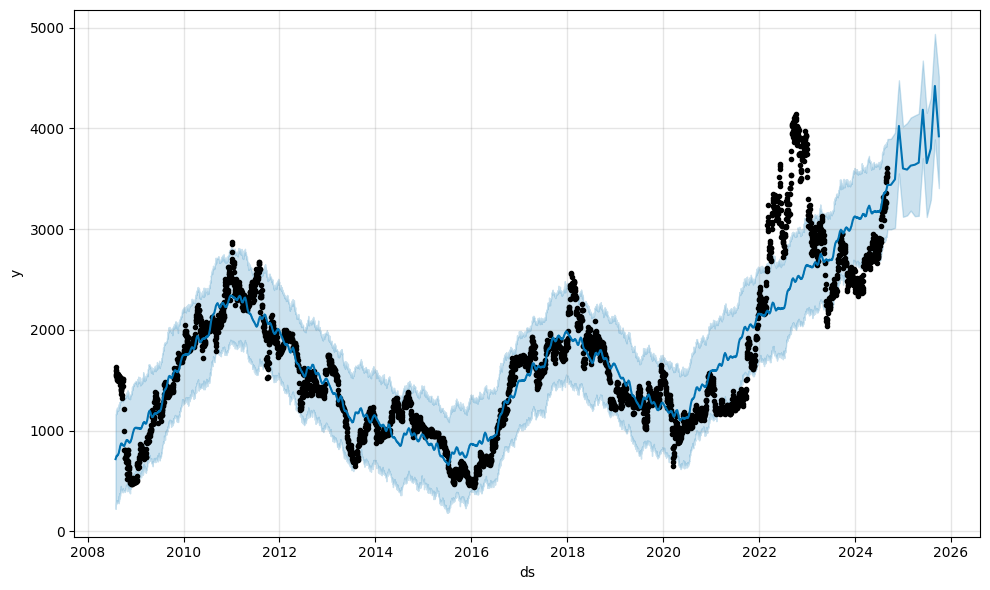

In [21]:
#Visualisai Prediksi
m_p.plot(prediction)
plt.show()

In [23]:
#Evaluation
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

In [24]:
#Melakukan Crossvalidation dengan training data 720 (2 tahun), prediksi 120 (4 bulan) dan interval waktunya 240 (8 bulan)
cv = cross_validation(m_p,initial='720 days', period='120 days', horizon = '240 days')

  0%|          | 0/41 [00:00<?, ?it/s]

20:47:09 - cmdstanpy - INFO - Chain [1] start processing
20:47:10 - cmdstanpy - INFO - Chain [1] done processing
20:47:11 - cmdstanpy - INFO - Chain [1] start processing
20:47:12 - cmdstanpy - INFO - Chain [1] done processing
20:47:12 - cmdstanpy - INFO - Chain [1] start processing
20:47:13 - cmdstanpy - INFO - Chain [1] done processing
20:47:14 - cmdstanpy - INFO - Chain [1] start processing
20:47:15 - cmdstanpy - INFO - Chain [1] done processing
20:47:15 - cmdstanpy - INFO - Chain [1] start processing
20:47:17 - cmdstanpy - INFO - Chain [1] done processing
20:47:17 - cmdstanpy - INFO - Chain [1] start processing
20:47:19 - cmdstanpy - INFO - Chain [1] done processing
20:47:19 - cmdstanpy - INFO - Chain [1] start processing
20:47:20 - cmdstanpy - INFO - Chain [1] done processing
20:47:21 - cmdstanpy - INFO - Chain [1] start processing
20:47:22 - cmdstanpy - INFO - Chain [1] done processing
20:47:23 - cmdstanpy - INFO - Chain [1] start processing
20:47:24 - cmdstanpy - INFO - Chain [1]

In [25]:
#Melihat hasil cv
cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-11-18,2248.187611,2136.390819,2361.311549,2450.0,2010-11-17
1,2010-11-19,2261.032671,2147.307435,2370.345827,2450.0,2010-11-17
2,2010-11-22,2262.105785,2150.051534,2376.772697,2450.0,2010-11-17
3,2010-11-23,2259.226906,2140.314823,2362.593259,2425.0,2010-11-17
4,2010-11-24,2260.244556,2140.160821,2372.332983,2400.0,2010-11-17


In [26]:
#Melihat performance metrics
df_pm= performance_metrics(cv)
df_pm.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,24 days,258251.201154,508.184220,363.216552,0.213376,0.158313,0.220352,0.391774
1,25 days,263278.553130,513.106766,368.302228,0.217203,0.162744,0.224347,0.379414
2,26 days,269126.425951,518.773964,373.169524,0.220221,0.167986,0.227605,0.369621
3,27 days,273772.705426,523.232936,375.815484,0.221616,0.170905,0.229067,0.366502
4,28 days,275632.614507,525.007252,377.224322,0.222479,0.174898,0.229427,0.366068


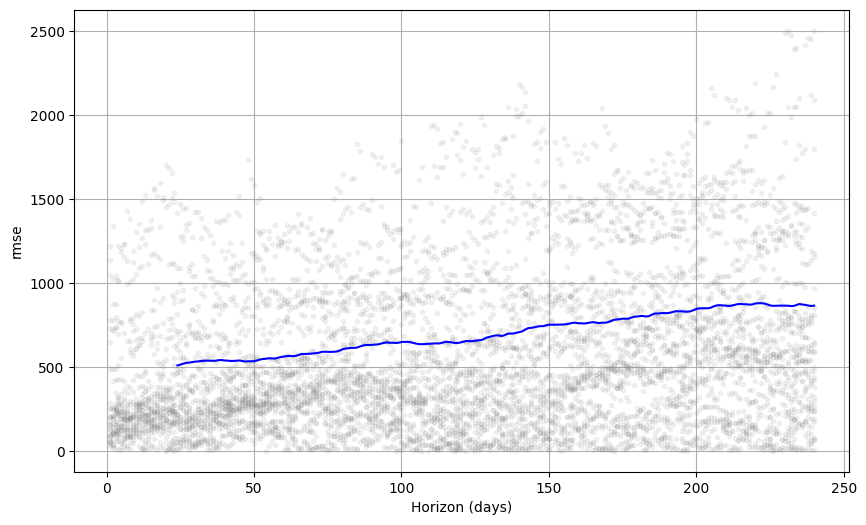

In [27]:
#Visualiasi RMSE
plot_cross_validation_metric(cv, metric='rmse')
plt.show()